In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
#training_data_filename = "training_data_OLCIS3A_L2_EFR_OC.npy"
training_data_filename = "training_data.npy"

Loaded 1582 entries from training_data.npy
First entry tuple length: 3
Tuple contents/types: [<class 'int'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Lengths/shapes of elements:
  Element 0: 121 (type <class 'int'>)
  Element 1: numpy array with shape (4,)
  Element 2: numpy array with shape (160,)
patch_flat length: 160


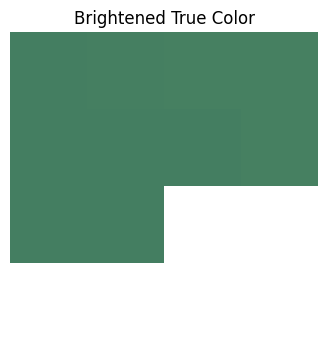

In [36]:
# Load the training data
try:
    data = np.load(training_data_filename, allow_pickle=True)
    print(f"Loaded {len(data)} entries from {training_data_filename}")
except FileNotFoundError:
    raise FileNotFoundError(f"{training_data_filename} not found in the current directory.")

# Inspect first entry to understand tuple structure
first_entry = data[100]
print(f"First entry tuple length: {len(first_entry)}")
print(f"Tuple contents/types: {[type(x) for x in first_entry]}")
print(f"Lengths/shapes of elements:")
for idx, elem in enumerate(first_entry):
    if isinstance(elem, np.ndarray):
        print(f"  Element {idx}: numpy array with shape {elem.shape}")
    else:
        try:
            print(f"  Element {idx}: {elem} (type {type(elem)})")
        except:
            print(f"  Element {idx}: type {type(elem)}")

# Assume structure is (row_index, labels_array, patch_flat_array)
# Adjust these indices if different.
patch_flat = first_entry[2]
print(f"patch_flat length: {patch_flat.size}")

# TODO: Set the correct (h, w, c) for your patches.
# You need to know the spatial dimensions (h, w) and number of bands (c).
# For example, if patch_flat.size == h * w * c, set:
# h, w, c = 9, 9, 3  # replace with your actual dimensions
# You can compute h*w = patch_flat.size / c once you know c, or vice versa.

# Example: try inferring c if you know number of bands used,
# e.g., bands = ["Rrs_488", "Rrs_555", "Rrs_667"] → c = 3.
# Then spatial_pixels = patch_flat.size // c, and if spatial_pixels is a perfect square,
# h = w = int(np.sqrt(spatial_pixels)).
# Otherwise, set h and w explicitly.

# Example inference (only if patch is square and c known):
c = 10
spatial_pixels = patch_flat.size // c
if spatial_pixels * c != patch_flat.size:
    raise ValueError("Flat size not divisible by c; adjust c or patch shape.")
side = int(np.sqrt(spatial_pixels))
if side * side != spatial_pixels:
    raise ValueError("Spatial dimension not square; set h and w manually.")
h, w = side, side

# Ensure patch_flat can reshape to (h, w, c)
if h is None or w is None or c is None:
    raise ValueError("Please set h, w, c to the correct patch dimensions before plotting.")

if patch_flat.size != h * w * c:
    raise ValueError(f"patch_flat size {patch_flat.size} does not match h*w*c = {h*w*c}")

# Reshape and plot RGB for the first entry
patch = patch_flat.reshape((h, w, c))

# TODO: Set the indices corresponding to Red, Green, Blue bands in your patch:
# For example, if bands order was ["Rrs_488", "Rrs_555", "Rrs_667"], then:
#    blue_idx = 0, green_idx = 1, red_idx = 2
red_idx = 7    # e.g., 2
green_idx = 6  # e.g., 1
blue_idx = 3   # e.g., 0

# after reshaping patch_flat → patch (h, w, c) and selecting R,G,B indices:
red = patch[:,:,red_idx]
green = patch[:,:,green_idx]
blue = patch[:,:,blue_idx]
rgb = np.stack([red, green, blue], axis=-1)  # reflectance array

# Normalize using fixed vmax:
vmax = 0.05  # adjust if your scene reflectance peaks lower/higher
rgb_norm = rgb / vmax
rgb_norm = np.clip(rgb_norm, 0, 1)

# Apply gamma correction:
gamma = 1/2.2  # or 1/1.5 for more brightness
rgb_plot = np.clip(rgb_norm ** gamma, 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(rgb_plot, origin='lower')
plt.axis('off')
plt.title("Brightened True Color")
plt.show()

# If you want to loop over multiple entries:
# for entry in data:
#     patch_flat = entry[2]
#     patch = patch_flat.reshape((h, w, c))
#     red = patch[:, :, red_idx]
#     green = patch[:, :, green_idx]
#     blue = patch[:, :, blue_idx]
#     rgb = np.stack([red, green, blue], axis=-1)
#     rgb_plot = np.clip(rgb ** (1/2.2), 0, 1)
#     plt.figure(figsize=(4,4))
#     plt.imshow(rgb_plot, origin='lower')
#     plt.title(f"Row {entry[0]}")
#     plt.axis('off')
#     plt.show()


Loaded 1582 entries from training_data.npy
Particulate: total=1582, >0 count=1557
Dissolved: total=1582, >0 count=1358


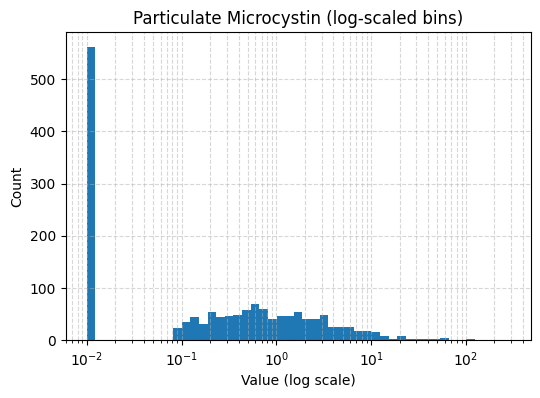

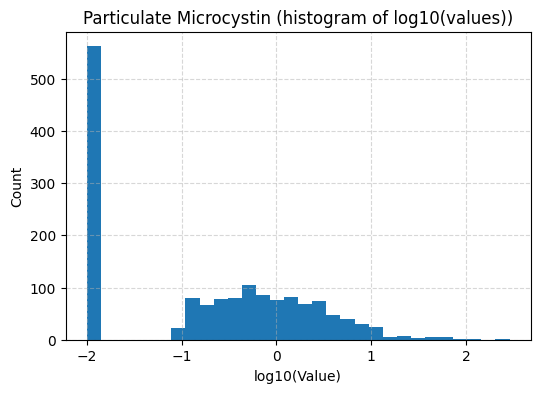

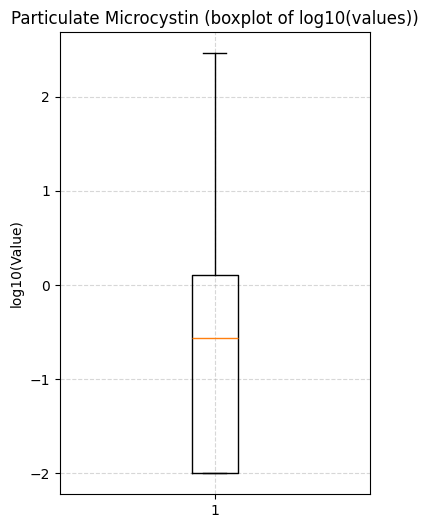

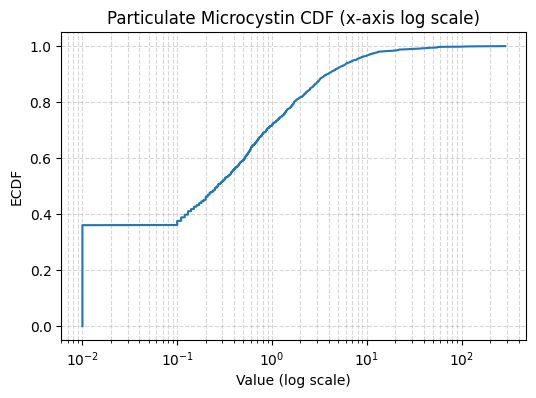

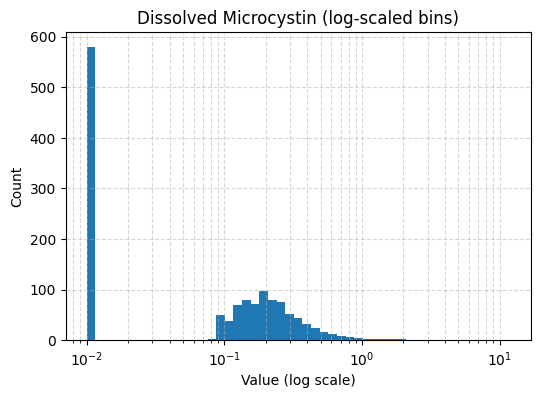

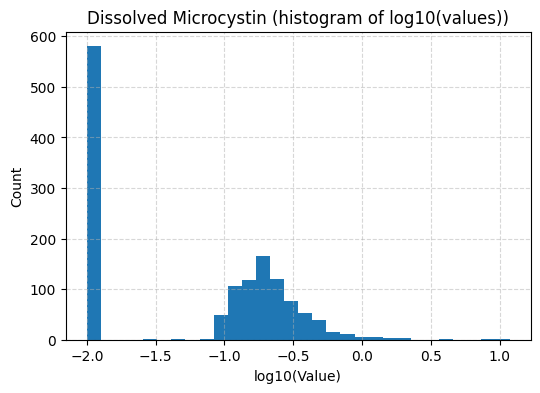

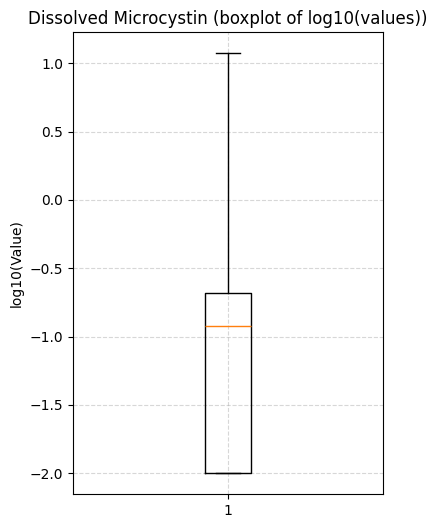

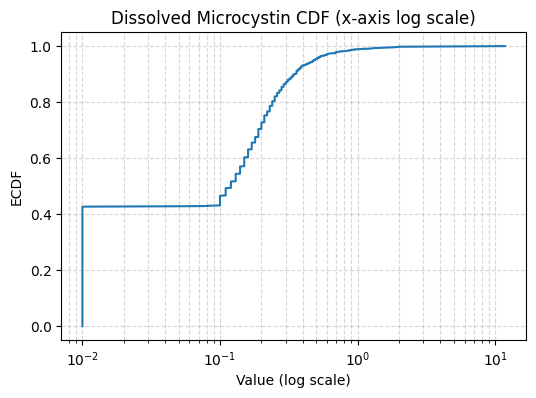

In [37]:
# Attempt to load the training data

if not os.path.exists(training_data_filename):
    print(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")
else:
    data = np.load(training_data_filename, allow_pickle=True)
    print(f"Loaded {len(data)} entries from {training_data_filename}")

    # Extract labels arrays, replacing NaN with 0
    partic_list = []
    dissolved_list = []
    for entry in data:
        labels = entry[1]  # (particulate, dissolved, ...)
        if labels is not None and len(labels) >= 2:
            partic_val = labels[0] if not np.isnan(labels[0]) else 0.0
            dissolved_val = labels[1] if not np.isnan(labels[1]) else 0.0
            partic_list.append(partic_val)
            dissolved_list.append(dissolved_val)

    partic = np.array(partic_list, dtype=float)
    dissolved = np.array(dissolved_list, dtype=float)

    # Only values > 0
    partic_positive = partic[partic > 0]
    dissolved_positive = dissolved[dissolved > 0]

    print(f"Particulate: total={len(partic)}, >0 count={len(partic_positive)}")
    print(f"Dissolved: total={len(dissolved)}, >0 count={len(dissolved_positive)}")

    # 1) Histogram with log-scaled x-axis and log-spaced bins
    def plot_log_histogram(values, title):
        # Determine bin edges in log space
        min_val = values.min()
        max_val = values.max()
        # Avoid issues if min_val is 0 (we have filtered >0)
        bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
        plt.figure(figsize=(6, 4))
        plt.hist(values, bins=bins)
        plt.xscale('log')
        plt.title(title + " (log-scaled bins)")
        plt.xlabel("Value (log scale)")
        plt.ylabel("Count")
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.show()

    # 2) Histogram of log-transformed values (linear bins on log values)
    def plot_hist_log_transformed(values, title):
        log_vals = np.log10(values)
        plt.figure(figsize=(6, 4))
        plt.hist(log_vals, bins=30)
        plt.title(title + " (histogram of log10(values))")
        plt.xlabel("log10(Value)")
        plt.ylabel("Count")
        plt.grid(True, ls='--', alpha=0.5)
        plt.show()

    # 3) Boxplot of log-transformed values
    def plot_boxplot_log(values, title):
        log_vals = np.log10(values)
        plt.figure(figsize=(4, 6))
        plt.boxplot(log_vals, vert=True)
        plt.title(title + " (boxplot of log10(values))")
        plt.ylabel("log10(Value)")
        plt.grid(True, ls='--', alpha=0.5)
        plt.show()

    # 4) Empirical CDF (on log scale)
    def plot_ecdf(values, title):
        sorted_vals = np.sort(values)
        n = len(sorted_vals)
        ecdf = np.arange(1, n + 1) / n
        plt.figure(figsize=(6, 4))
        plt.plot(sorted_vals, ecdf)
        plt.xscale('log')
        plt.title(title + " CDF (x-axis log scale)")
        plt.xlabel("Value (log scale)")
        plt.ylabel("ECDF")
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.show()

    # Plot for particulate_microcystin > 0
    plot_log_histogram(partic_positive, "Particulate Microcystin")
    plot_hist_log_transformed(partic_positive, "Particulate Microcystin")
    plot_boxplot_log(partic_positive, "Particulate Microcystin")
    plot_ecdf(partic_positive, "Particulate Microcystin")

    # Plot for dissolved_microcystin > 0
    plot_log_histogram(dissolved_positive, "Dissolved Microcystin")
    plot_hist_log_transformed(dissolved_positive, "Dissolved Microcystin")
    plot_boxplot_log(dissolved_positive, "Dissolved Microcystin")
    plot_ecdf(dissolved_positive, "Dissolved Microcystin")


In [ ]:
import os
import numpy as np
import pandas as pd

if not os.path.exists(training_data_filename):
    raise FileNotFoundError(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")

# Load the training data
data = np.load(training_data_filename, allow_pickle=True)
print(f"Loaded {len(data)} entries from {training_data_filename}")

# Extract total microcystin (particulate + dissolved), replacing NaN with 0
total_list = []
for entry in data:
    labels = entry[1]  # expecting [particulate, dissolved, ...]
    if labels is None or len(labels) < 2:
        # If labels missing, treat as zeros
        total_list.append(0.0)
    else:
        part = labels[0] if not np.isnan(labels[0]) else 0.0
        diss = labels[1] if not np.isnan(labels[1]) else 0.0
        total_list.append(part + diss)

total = np.array(total_list, dtype=float)

# Compute counts for thresholds
thresholds = [1, 10, 20]
summary = []
n_total = len(total)
for th in thresholds:
    count = np.sum(total > th)
    pct = (count / n_total) * 100 if n_total > 0 else np.nan
    summary.append({"threshold (µg/L)": th, "count > threshold": count, "percentage (%)": pct})

# Create a DataFrame for display
df_summary = pd.DataFrame(summary)

# Display the summary
import matplotlib.pyplot as plt

print(df_summary)

# Optionally, plot bar chart of counts
plt.figure(figsize=(6, 4))
plt.bar(df_summary["threshold (µg/L)"].astype(str), df_summary["count > threshold"])
plt.xlabel("Threshold (µg/L) for Total Microcystin")
plt.ylabel("Number of Entries > Threshold")
plt.title("Counts of Entries with Total Microcystin Above Thresholds")
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

# Optionally, plot percentage
plt.figure(figsize=(6, 4))
plt.bar(df_summary["threshold (µg/L)"].astype(str), df_summary["percentage (%)"])
plt.xlabel("Threshold (µg/L) for Total Microcystin")
plt.ylabel("Percentage of Entries > Threshold")
plt.title("Percentage of Entries with Total Microcystin Above Thresholds")
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()


In [38]:
if not os.path.exists(training_data_filename):
    raise FileNotFoundError(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")

# Load the training data
data = np.load(training_data_filename, allow_pickle=True)
print(f"Loaded {len(data)} entries from {training_data_filename}")

# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[2]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")

n_samples = len(data)
n_features = first_patch.size

# Initialize feature and label arrays
X = np.zeros((n_samples, n_features), dtype=float)
y = np.zeros(n_samples, dtype=int)

# Populate X and y
for idx, entry in enumerate(data):
    _, labels, patch_flat = entry
    # Feature: flatten reflectance array; assume consistent size
    patch_arr = patch_flat
    if patch_arr.size != n_features:
        raise ValueError(f"Inconsistent feature size at entry {idx}: expected {n_features}, got {patch_arr.size}")
    # Optionally handle NaNs in features; e.g., replace NaN with 0
    patch_arr = np.nan_to_num(patch_arr, nan=0.0)
    X[idx, :] = patch_arr

    # Label: total microcystin > 0.1 µg/L
    if labels is None or len(labels) < 2:
        total = 0.0
    else:
        part = labels[0] if not np.isnan(labels[0]) else 0.0
        diss = labels[1] if not np.isnan(labels[1]) else 0.0
        total = part + diss
    y[idx] = 1 if part > 0.25 else 0

# Display class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):", dict(zip(unique, counts)))

# Save feature and label arrays if desired
np.save("X.npy", X)
np.save("y.npy", y)
print(f"Saved features to X.npy and labels to y.npy. X shape: {X.shape}, y shape: {y.shape}")


Loaded 1582 entries from training_data.npy
Class distribution (label: count): {np.int64(0): np.int64(794), np.int64(1): np.int64(788)}
Saved features to X.npy and labels to y.npy. X shape: (1582, 160), y shape: (1582,)
